# BHB formation channels with gaussian mixtures

Tasks
1. Load this file (np.load) and complete a quick exploration of the data. How many modes do you think you see?
2. We'll use sklearn.mixture.GaussianMixture. You first need to define the model (instance of a class), and then train it on the data using the fit method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.
3. Complete the fit 10 times with many Gaussians.
4. For each of this fits, compute the AIC (easy! It's an attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?
5. Plot the preferred solution on top of the input data. You should get a very nice fit!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sysb
sys.path.append(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities')
from Utilities import plot_settings

In [7]:
data = np.load(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Exam\Data\formationchannels.npy')

Text(0, 0.5, 'Data value')

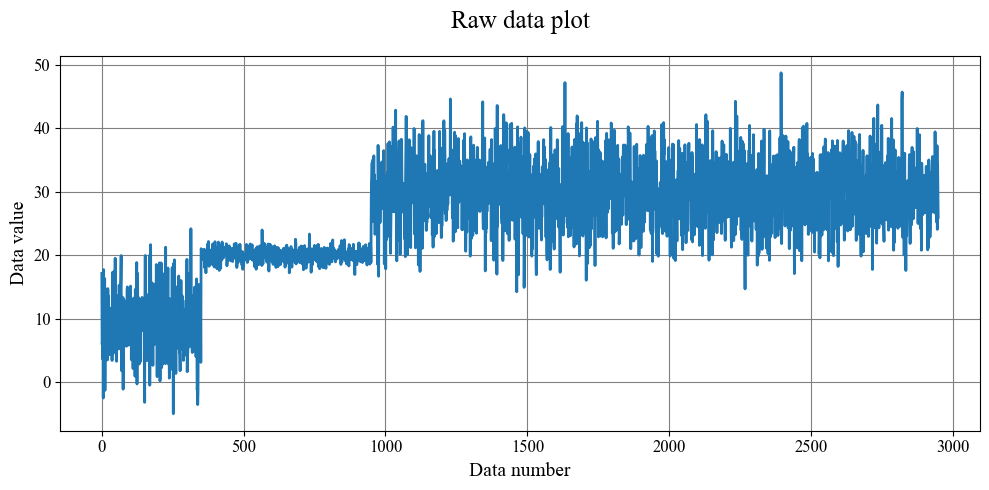

In [8]:
plt.plot(data.T[0])
plt.title('Raw data plot')
plt.xlabel('Data number')
plt.ylabel('Data value')

Probably this can be called out as cheating, but it is cristal clear from the upper plot that data vary around a mean value of 10 with a big sigma, then around 20 with a small sigma, then around 30 with a bigger sigma. I expect the algorithm to return 3 as the best number of modes. Let's pretend not to have seen this.

Text(0, 0.5, 'Frequencies')

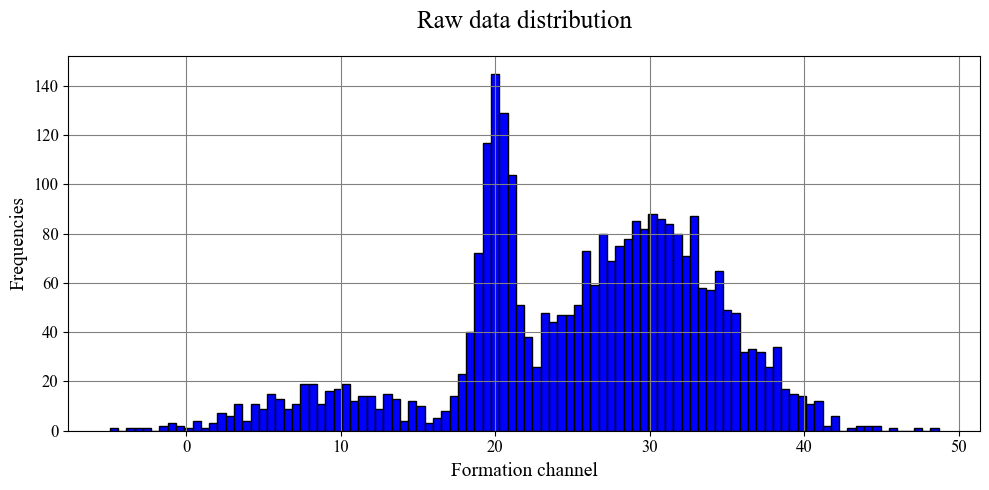

In [9]:
c, b ,_ = plt.hist(data, bins=100, density=False, histtype='barstacked', color='blue', edgecolor='black')
plt.title('Raw data distribution')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')

We can see clearly 3 peaks... Let's dive into a more quantitative approach

In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

Separate data for training the GaussianMixture class instance and testing it

In [11]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

We'd like to see what happens changing as the number of gaussians changes from 0 to 10

In [16]:
Ns = np.linspace(2,10,8, dtype=int)

In [17]:
x_plot = np.linspace(min(data.T[0]), max(data.T[0]), 1000)


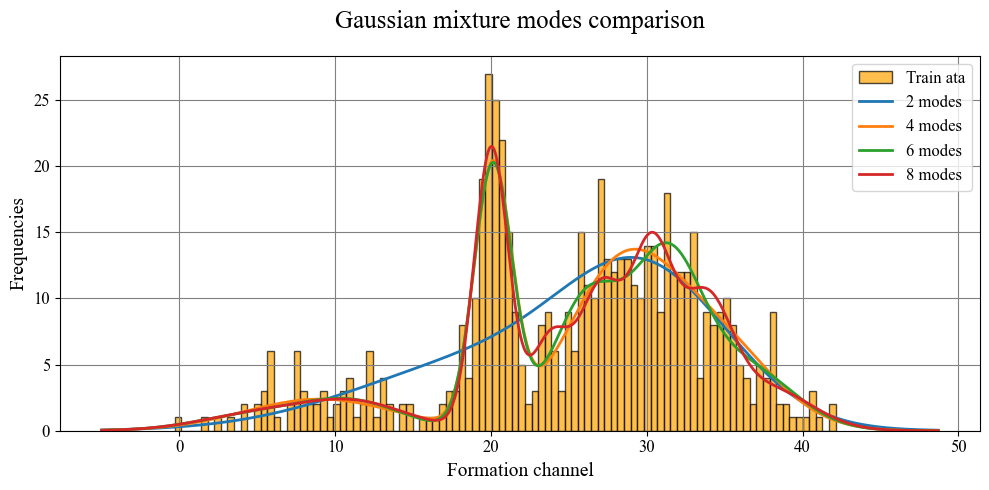

In [18]:
AICs = []
c2, b2 ,_ = plt.hist(test, bins=100, density=False, histtype='barstacked', color='orange', alpha=0.7, edgecolor='black', label='Train ata')
bin_centers2 = 0.5 * (b2[:-1] + b2[1:])
for n in Ns:
    Gauss = GaussianMixture(int(n))
    Gauss.fit(train)
    predicted_loglike = Gauss.score_samples(test)
    AICs.append(Gauss.aic(test))
    if n in Ns[::2]:
        plt.plot(x_plot, np.exp(Gauss.score_samples(x_plot.reshape(-1,1)))*c2.sum()*(b2[1]-b2[0]), linewidth=2, label=f'{n} modes')
plt.title('Gaussian mixture modes comparison')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')
plt.legend()

AIC $= -2\ln(L^{0}(M)) + 2k+ \frac{2k(k+1)}{N-k-1} \to$  the lesser the better

Text(0.5, 1.0, 'AIC vs Number of gaussian modes')

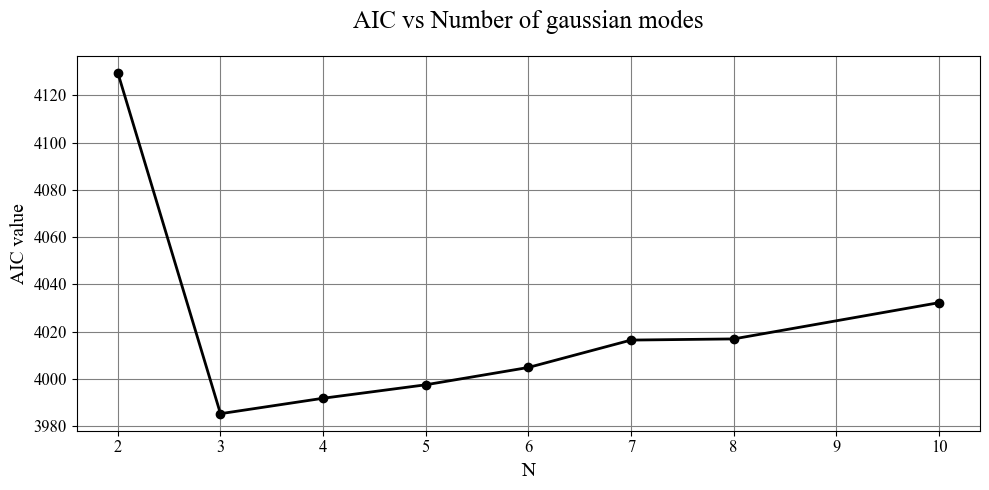

In [19]:
plt.plot(Ns, AICs, marker='o', color='black')
plt.xlabel('N')
plt.ylabel('AIC value')
plt.title('AIC vs Number of gaussian modes')

The AIC statistic reaches a minimum at N=3. This will be our best model.

In [20]:
Gauss = GaussianMixture(3, means_init=np.array([10,20,30]).reshape(-1,1))

In [21]:
Gauss.fit(train)

GaussianMixture(means_init=array([[10.],
       [20.],
       [30.]]),
                n_components=3)

In [22]:
Gauss.means_

array([[ 8.92669508],
       [20.07124825],
       [30.18510706]])

In [23]:
for i in range(3):
    print(f'Gaussian-{i}: {Gauss.means_[i]},{Gauss.covariances_[i]}')
Gauss.weights_

Gaussian-0: [8.92669508],[[23.10722132]]
Gaussian-1: [20.07124825],[[1.22274211]]
Gaussian-2: [30.18510706],[[24.49303896]]


array([0.11465727, 0.2132989 , 0.67204383])

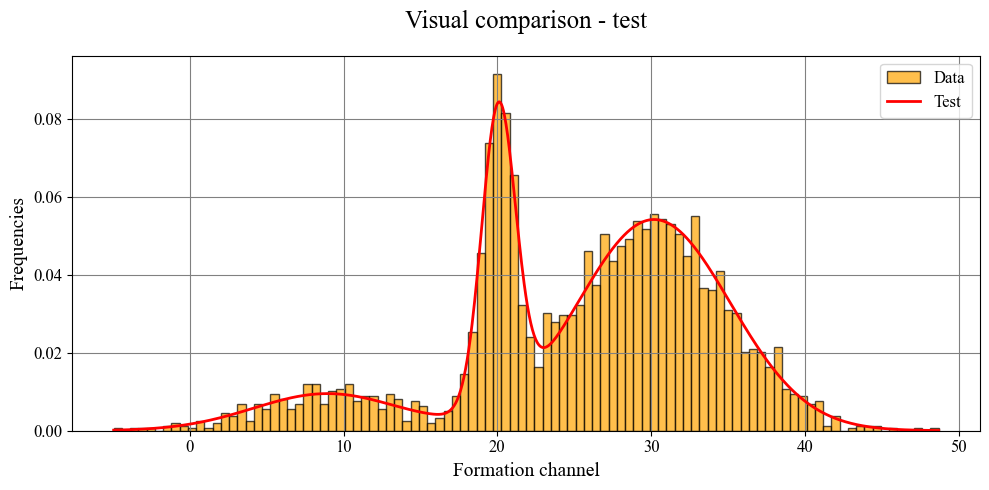

In [24]:
c3, b3,_ = plt.hist(data, bins=100, density=True, histtype='barstacked', color='orange', alpha=0.7, edgecolor='black', label='Data')
plt.plot(x_plot, np.exp(Gauss.score_samples(x_plot.reshape(-1,1))), linewidth=2, color='red', label='Test')
plt.title('Visual comparison - test')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')
plt.legend()

6. Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset.
Hint: Useful methods here are score_samples and predict_proba

This refers to maximization-expectation algorithm. Instead of solving a system containing $3M-1$ linear equations to determine all the triplets $\alpha_j, \mu_j, \sigma_j$ one can label a datum where the label corresponds to one of the modes that governs the given data set. Each class probability is given by Bayes theorem:

$p(j|x_i) = \frac{p(j) p_j(x_i|\theta)}{\sum_{j=1}^{M}p(j)(x_i|\theta)} = \frac{\alpha_j \mathcal{N}(\mu_j,\sigma_j)}{\sum_{j=1}^{M}\alpha_j \mathcal{N}(\mu_j,\sigma_j)}$

In [25]:
labels = Gauss.predict(data)

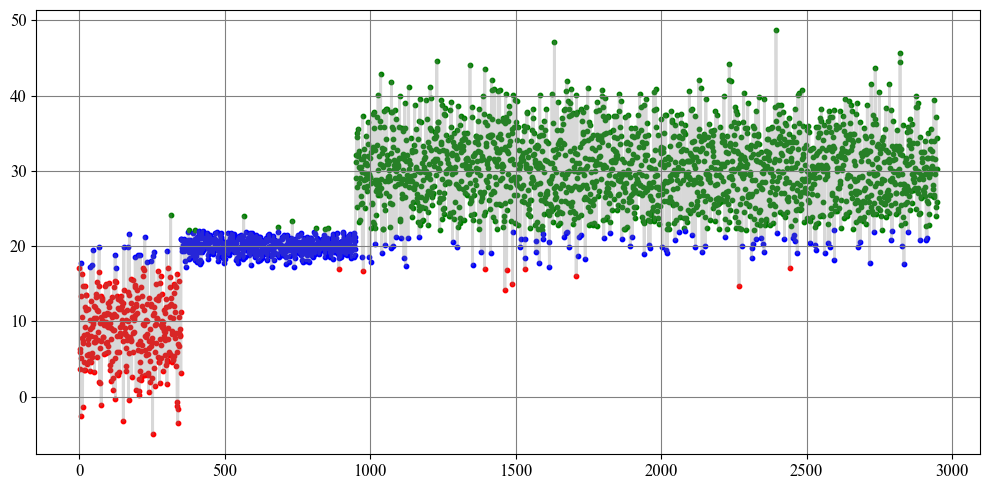

In [26]:
# Color map (fixed order: label 0 → red, 1 → blue, 2 → green)
colors = ['red', 'blue', 'green']

# Plot the full data as a semi-transparent line
plt.plot(data, color='gray', alpha=0.3, label='Raw data')

# Overlay each point with its component color
for i, (datum, label) in enumerate(zip(data.T[0], labels)):
    plt.scatter(i, datum, color=colors[label], s=10)

## ML approach

Let's try with some AI machinary, namely clustering. I'll try at first with K-Means clustering, then switching to Mean-Shift.

### K-Means

In [33]:
from sklearn.cluster import KMeans, MeanShift
from sklearn.model_selection import train_test_split

In [28]:
nclusters = 3

In [35]:
KM = KMeans(nclusters, init='k-means++',tol=1e-6, verbose=1, random_state=42, copy_x=False)

In [36]:
KM.fit(train)

Initialization complete
Iteration 0, inertia 61186.86434403814.
Iteration 1, inertia 29519.13571762282.
Iteration 2, inertia 27537.833635773794.
Iteration 3, inertia 26855.58464580906.
Iteration 4, inertia 26633.63604932169.
Iteration 5, inertia 26589.467922578326.
Iteration 6, inertia 26577.87728959002.
Iteration 7, inertia 26575.552292620836.
Converged at iteration 7: center shift 5.087923249109392e-05 within tolerance 7.18935843182779e-05.


KMeans(copy_x=False, n_clusters=3, random_state=42, tol=1e-06, verbose=1)

In [63]:
predicted = KM.fit_predict(data)

Initialization complete
Iteration 0, inertia 41573.035218035344.
Iteration 1, inertia 34811.69215017557.
Iteration 2, inertia 33263.026405685785.
Iteration 3, inertia 32912.68159392738.
Iteration 4, inertia 32781.53603215703.
Iteration 5, inertia 32724.831835902078.
Iteration 6, inertia 32709.366328475608.
Iteration 7, inertia 32698.66710850278.
Iteration 8, inertia 32692.117714181288.
Iteration 9, inertia 32688.554628656722.
Iteration 10, inertia 32687.630818549405.
Iteration 11, inertia 32686.311601166868.
Iteration 12, inertia 32685.841270226767.
Converged at iteration 12: strict convergence.


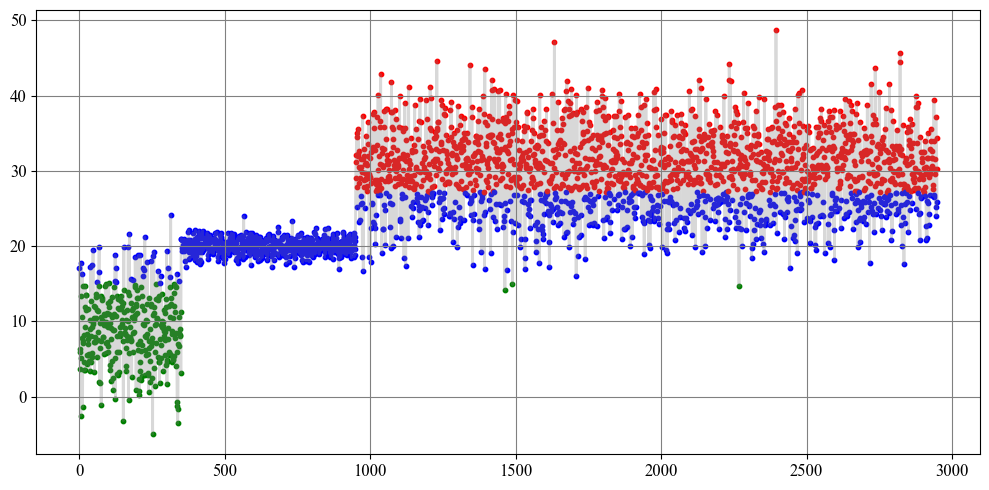

In [ ]:
plt.plot(data.T[0], color='gray', alpha=0.3, label='Raw data')
for i, (datum, pred) in enumerate(zip(data.T[0], predicted)):
    plt.scatter(i, datum, color=colors[pred], s=10)
plt.title('K-Means prediction')

In [66]:
MS = MeanShift()

In [86]:
MS.fit(train)

MeanShift()

In [87]:
MS_predict = MS.fit_predict(data)

In [88]:
MS_predict

array([1, 2, 2, ..., 0, 0, 0], shape=(2950,))

Text(0.5, 1.0, 'Mean-Shift prediction')

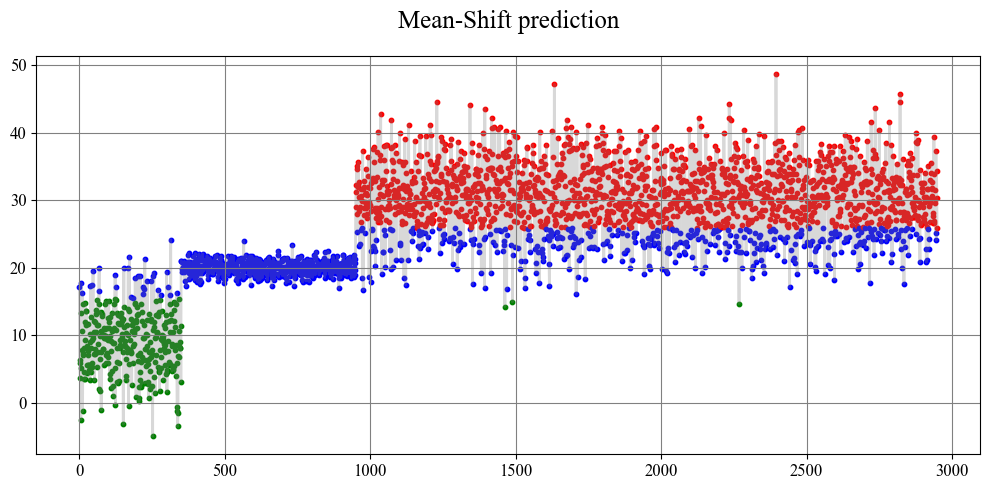

In [89]:
plt.plot(data.T[0], color='gray', alpha=0.3, label='Raw data')
for i, (datum, pred) in enumerate(zip(data.T[0], MS_predict)):
    plt.scatter(i, datum, color=colors[pred], s=10)
plt.title('Mean-Shift prediction')

In [90]:
reds = test[MS.fit_predict(test)==2]
greens = test[MS.fit_predict(test)==2]
blus = test[MS.fit_predict(test)==2]

since I know how data were generated...

In [74]:
random_state = np.random.RandomState(seed=1)

In [75]:
X = np.concatenate([random_state.normal(9, 5, 350),
                    random_state.normal(20, 1, 600),
                    random_state.normal(30, 5, 2000)]).reshape(-1, 1)

In [76]:
y_true = np.concatenate([
    np.full(350, 0),  # label 0
    np.full(600, 1),  # label 1
    np.full(2000, 2)  # label 2
])

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming X is already shaped (2950, 1)
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)

# Get soft probabilities
probs = gmm.predict_proba(X)  # shape (2950, 3)i

In [78]:
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_true, classes=[0, 1, 2])  # shape (2950, 3)

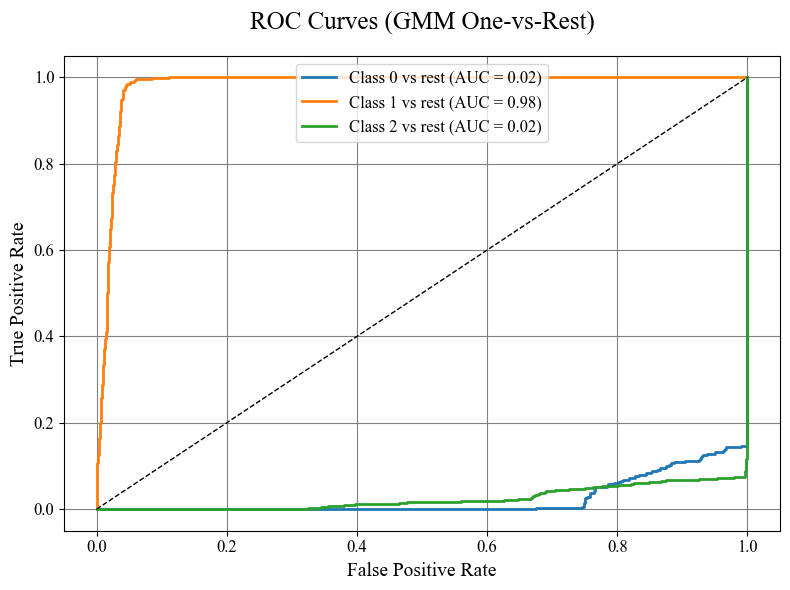

In [79]:
plt.figure(figsize=(8, 6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} vs rest (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (GMM One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.tight_layout()